In [29]:
import pandas as pd
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
from itertools import chain
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\remoteUser\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\remoteUser\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\remoteUser\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\remoteUser\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


True

In [31]:
data = pd.read_csv('fake_or_real_news.csv',usecols=['title','text','label'])

In [32]:
data

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...
6330,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [33]:
data = data.drop_duplicates()

In [34]:
print(f"Features: {', '.join(data.columns)}")
print(f'Numero de filas: {data.shape[0]}')
print(f'Numero de Columnas: {data.shape[1]}')

Features: title, text, label
Numero de filas: 6306
Numero de Columnas: 3


### Analisis nulls

In [35]:
df_dtypes = pd.merge(data.isnull().sum(axis = 0).sort_values().to_frame('missing_value').reset_index(),
         data.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')
df_dtypes

,index,missing_value,feature_type
0,title,0,object
1,text,0,object
2,label,0,object


### Analisis target

<AxesSubplot:xlabel='label', ylabel='Count'>

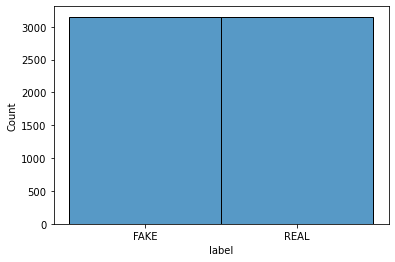

In [36]:
sns.histplot(x='label', data=data,discrete=True)

#### Convertir label a binaria

In [37]:
data['label'] = data['label'].map({'REAL':0,'FAKE':1}) 

C:\Users\remoteUser\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
data = data[['text','label']]

In [39]:
data.to_csv('fake_or_real_cleaned.csv')

### Analisis palabras en text

Eliminar caracteres especiales

In [11]:
data['text'] = data.text.str.lower().str.strip()

In [12]:
translator = str.maketrans('', '', string.punctuation+'’‘—“”–')
data["text"] = data['text'].map(lambda x: x.strip().lower().translate(translator))

Eliminar stopwords

In [13]:
stopwords = nltk.corpus.stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()
data['text'] = data['text'].map(word_tokenize).apply(lambda x: [word for word in x if word not in stopwords])
data['text']

0       [daniel, greenfield, shillman, journalism, fel...
1       [google, pinterest, digg, linkedin, reddit, st...
2       [us, secretary, state, john, f, kerry, said, m...
3       [kaydee, king, kaydeeking, november, 9, 2016, ...
4       [primary, day, new, york, frontrunners, hillar...
                              ...                        
6330    [state, department, told, republican, national...
6331    [p, pbs, stand, plutocratic, pentagon, posted,...
6332    [antitrump, protesters, tools, oligarchy, ref...
6333    [addis, ababa, ethiopia, president, obama, con...
6334    [jeb, bush, suddenly, attacking, trump, heres,...
Name: text, Length: 6306, dtype: object

Lemmatize

In [14]:
data['text'] = data['text'].apply(lambda x: [wordnet_lemmatizer.lemmatize(w, pos="v") for w in x])

WordCount

<AxesSubplot:>

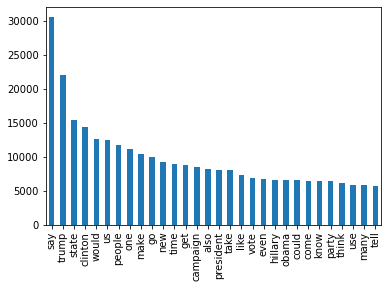

In [15]:
all_words = list(chain(*data['text']))
pd.Series(Counter(all_words)).sort_values(ascending=False).iloc[:30].plot(kind="bar")

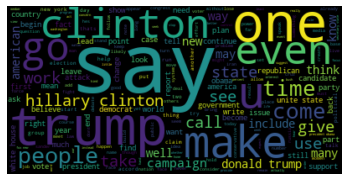

In [16]:
text_join = ' '.join(all_words)
wordcloud = WordCloud().generate(text_join)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Vectorizer

In [17]:
corpus = data['text'].apply(lambda x: ' '.join(x)).to_numpy()
corpus

array(['daniel greenfield shillman journalism fellow freedom center new york writer focus radical islam final stretch election hillary rodham clinton go war fbi word unprecedented throw around often election ought retire still unprecedented nominee major political party go war fbi thats exactly hillary people do coma patients wake watch hour cnn hospital bed would assume fbi director jam comey hillarys opponent election fbi attack everyone obama cnn hillarys people circulate letter attack comey currently media hit piece lambast target trump wouldnt surprise clintons ally start run attack ads fbi fbis leadership warn entire leftwing establishment form lynch mob continue go hillary fbis credibility attack media democrats preemptively head result investigation clinton foundation hillary clinton covert struggle fbi agents obamas doj people go explosively public new york time compare comey j edgar hoover bizarre headline jam comey role recall hoover fbi fairly practically admit front spout 

tengo que ver que hacer con los \x92 \x93 \x94

Probar Modelos

In [18]:
vectorizer = TfidfVectorizer(strip_accents="ascii")
vectors = vectorizer.fit_transform(corpus)

In [19]:
feature_names = vectorizer.get_feature_names_out()
dense = vectors.todense()
denselist = dense.tolist()

In [20]:
X = pd.DataFrame(denselist, columns=feature_names)
y = data['label']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)

In [26]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
score = logreg.score(X_test, y_test)
score

0.9099556119213696

In [28]:
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(X_train,y_train)
y_pred=pac.predict(X_test)
accuracy_score(y_test,y_pred)

0.9207355738744452